In [1]:
import pandas as pd
import numpy as np
from patternly.detection import AnomalyDetection
from sklearn.cluster import KMeans

original = pd.read_csv("./01_2015_LANL-01A_SOPA_MPA.txt", low_memory=False).dropna(how="any", axis=0)

In [2]:
start_col = 0
end_col = 3
window_size = 1000
n_clusters = 2
predictions = pd.DataFrame()
pipelines = []

for i in range(start_col, end_col):
    data = original.iloc[:,i+1].reset_index(drop=True).replace(-1e+31, np.nan).dropna(how="all", axis=0)
    seqs = pd.concat(
        [data[(window_size * j):(window_size * (j + 1))].reset_index(drop=True) for j in range(int(data.shape[0]/window_size))], 
        axis=1
    ).T

    kmeans = KMeans(n_clusters=n_clusters)
    pipelines.append(
        AnomalyDetection(
            anomaly_sensitivity=1, 
            clustering_alg=kmeans,
            quantize_type="simple",
            eps=0.05,
            verbose=False,
        )
    )
    pipelines[i - start_col].fit(seqs)

    predictions = pd.concat([predictions, pd.DataFrame(pipelines[i - start_col].predict())], axis=1)

predictions.columns = range(predictions.shape[1])

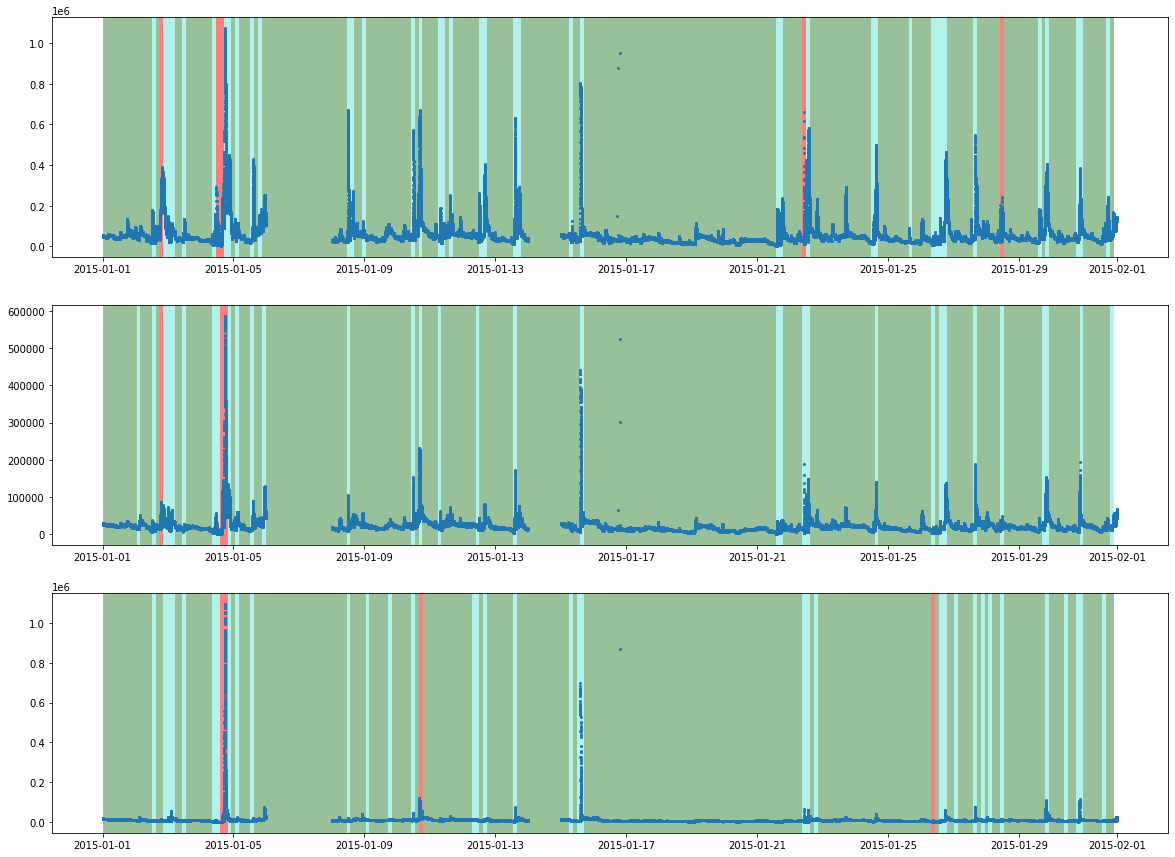

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
plt.rcParams["figure.figsize"] = (20,15)

start = datetime.strptime(original.iloc[:,0][0], "%Y-%m-%d %H:%M:%S.%f%z")
end = datetime.strptime(original.iloc[:,0][original.shape[0]-1], "%Y-%m-%d %H:%M:%S.%f%z")

dts = pd.DataFrame([datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f%z") for date in original.iloc[:,0][:]])
dts.index = original.index

for i in range(start_col, end_col):
    seqs = original.iloc[:,i+1].to_frame().replace(-1e+31, np.nan).dropna(how="all", axis=0)
    data = pd.concat([seqs, dts], axis=1).dropna(how="any", axis=0)
    data.columns = ["val", "ts"]
    
    plt.subplot(end_col - start_col, 1, i + 1 - start_col)
#     plt.ylim(top=1e6)
    plt.plot_date(data["ts"], data["val"].T.values.tolist(), markersize=2)
    
    anoms = list(predictions[predictions[i - start_col] == True].index)
    for index in anoms:
        beg = data["ts"].iloc[index * window_size]
        end = data["ts"].iloc[index * window_size + window_size]
        plt.axvspan(beg, end, color='red', alpha=0.5, lw=0)
    
    # rank clusters for coloring
    cluster_counts = [0 for j in range(n_clusters)]
    for cluster in pipelines[i - start_col].closest_match:
        cluster_counts[cluster] += 1
    cluster_rank = np.flip(np.argsort(cluster_counts))
        
    for index in predictions.index:
        if index in anoms:
            continue
        beg = data["ts"].iloc[index * window_size]
        end = data["ts"].iloc[index * window_size + window_size]
        colors = ["darkgreen", "turquoise", "gray", "navy"]
        plt.axvspan(beg, end, color=colors[cluster_rank[pipelines[i - start_col].closest_match[index]]], alpha=0.4, lw=0)


plt.show()

In [4]:
from IPython.display import Image, display
from IPython.core.display import HTML

# column 1 PFSAs
for i, file in enumerate(pipelines[0].dot_files):
    print(f"Cluster {i}")
    display(Image(url=f"{file}.png", width=300))

Cluster 0


Cluster 1


In [5]:
# column 2 PFSAs
for i, file in enumerate(pipelines[1].dot_files):
    print(f"Cluster {i}")
    display(Image(url=f"{file}.png", width=300))

Cluster 0


Cluster 1


In [6]:
# column 3 PFSAs
for i, file in enumerate(pipelines[2].dot_files):
    print(f"Cluster {i}")
    display(Image(url=f"{file}.png", width=300))

Cluster 0


Cluster 1
